### notes and samples 

In [3]:
pd.offsets.__all__

['Day',
 'BaseOffset',
 'BusinessDay',
 'BusinessMonthBegin',
 'BusinessMonthEnd',
 'BDay',
 'CustomBusinessDay',
 'CustomBusinessMonthBegin',
 'CustomBusinessMonthEnd',
 'CDay',
 'CBMonthEnd',
 'CBMonthBegin',
 'MonthBegin',
 'BMonthBegin',
 'MonthEnd',
 'BMonthEnd',
 'SemiMonthEnd',
 'SemiMonthBegin',
 'BusinessHour',
 'CustomBusinessHour',
 'YearBegin',
 'BYearBegin',
 'YearEnd',
 'BYearEnd',
 'QuarterBegin',
 'BQuarterBegin',
 'QuarterEnd',
 'BQuarterEnd',
 'LastWeekOfMonth',
 'FY5253Quarter',
 'FY5253',
 'Week',
 'WeekOfMonth',
 'Easter',
 'Tick',
 'Hour',
 'Minute',
 'Second',
 'Milli',
 'Micro',
 'Nano',
 'DateOffset']

In [4]:
pd.offsets.MonthBegin._prefix # 'MS'
pd.offsets.WeekOfMonth._prefix

'WOM'

## Dataset 
Traffic cameras in the city of Heidelberg
The dataset contains an observation of the traffic flow at a specific place and time. It contains current and past measurements from traffic cameras in the city of Heidelberg (measurement interval: 15 min).
In addition to general location information, each dataset contains, if available, information on the number of vehicles and vehicle types measured, the average distance between vehicles and their passing time.
A detailed description of the dataset,the specification, and the raw data can be found here: 
https://ckan.datenplattform.heidelberg.de/de/dataset/mobility_main_trafficcamera

### Research Questions and machine learning objective 
How does traffic intensity vary throughout the day?

We will analyze the intensity of traffic at different times of the day to identify peak traffic hours. This involves aggregating traffic data by hour and visualizing the average traffic intensity.

Does traffic intensity vary by vehicleType?
We aim to explore whether certain types of vehicles are more prevalent during specific times or in certain locations, contributing differently to overall traffic intensity.


Machine Learning Model:
Objective: Predict the traffic intensity based on time of day, location (latitude and longitude), and vehicleType.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings



In [6]:
Bergheimer_Straße_B37 ='b95871b2-7de0-46b1-b377-db497250f8a0.csv'
data = pd.read_csv(Bergheimer_Straße_B37)


### Initial analysis and data wrangling 

#### Merging all datasets

In [7]:
null =[col for col in data.columns if data[col].isna().sum() == data.shape[0]]
data = data.drop(columns = null)

In [8]:
col_to_check = ['fiwareServicePath','entityId','entityType','addressLocality','addressCountry']
for col in col_to_check:
    print(data[col].unique())

['/main/trafficcamera']
['urn:ngsiv2:TrafficFlowObserved:2d458741-2a9a-45ba-a062-f8a790a976aa']
['TrafficFlowObserved']
['Heidelberg']
['Deutschland']


In [9]:
data = data.drop(columns = col_to_check) 

In [10]:
data

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress
0,1,2022-11-03T14:05:24.567Z,49.408167,69115,car,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,243,Bergheimer Straße B37
1,2,2022-11-03T14:05:24.617Z,49.408167,69115,motorcycle,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,5,Bergheimer Straße B37
2,3,2022-11-03T14:05:24.666Z,49.408167,69115,van,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,44,Bergheimer Straße B37
3,4,2022-11-03T14:05:24.666Z,49.408167,69115,lorry,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,46,Bergheimer Straße B37
4,5,2022-11-03T14:15:20.829Z,49.408167,69115,car,8.66825,2022-11-03T14:10:00.000Z,2022-11-03T14:10:00.000Z,2022-11-03T13:55:00.000Z,273,Bergheimer Straße B37
...,...,...,...,...,...,...,...,...,...,...,...
116466,116883,2024-02-01T09:00:21.544Z,49.408167,69115,lorry,8.66825,2024-02-01T08:55:00.000Z,2024-02-01T08:55:00.000Z,2024-02-01T08:40:00.000Z,10,Bergheimer Straße B37
116467,116884,2024-02-01T09:15:21.380Z,49.408167,69115,car,8.66825,2024-02-01T09:10:00.000Z,2024-02-01T09:10:00.000Z,2024-02-01T08:55:00.000Z,22,Bergheimer Straße B37
116468,116885,2024-02-01T09:15:21.666Z,49.408167,69115,motorcycle,8.66825,2024-02-01T09:10:00.000Z,2024-02-01T09:10:00.000Z,2024-02-01T08:55:00.000Z,2,Bergheimer Straße B37
116469,116886,2024-02-01T09:15:21.872Z,49.408167,69115,van,8.66825,2024-02-01T09:10:00.000Z,2024-02-01T09:10:00.000Z,2024-02-01T08:55:00.000Z,4,Bergheimer Straße B37


In [11]:
data = data.drop_duplicates()
data = data.reset_index(drop =True)

#### Converting formats

In [12]:
# Converting the types
data['recvTime'] = pd.to_datetime(data['recvTime'])
data['dateObserved'] = pd.to_datetime(data['dateObserved'])
data['dateObservedFrom'] = pd.to_datetime(data['dateObservedFrom'])
data['dateObservedTo'] = pd.to_datetime(data['dateObservedTo'])

In [13]:
data['hourOfDay'] = data['dateObserved'].dt.hour
data['date'] = data['dateObserved'].dt.date
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['days_of_week'] = pd.DatetimeIndex(data['date']).day_name()
data['date'] =pd.to_datetime(data['date'])

####  Checking for gaps in time series 

In [14]:
data.dtypes

_id                               int64
recvTime            datetime64[ns, UTC]
latitude                        float64
postalCode                        int64
vehicleType                      object
longitude                       float64
dateObservedTo      datetime64[ns, UTC]
dateObserved        datetime64[ns, UTC]
dateObservedFrom    datetime64[ns, UTC]
intensity                         int64
streetAddress                    object
hourOfDay                         int32
date                     datetime64[ns]
year                              int32
month                             int32
days_of_week                     object
dtype: object

In [15]:
data[data['date']== '2022-11-09'].head(50)

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress,hourOfDay,date,year,month,days_of_week
1730,1731,2022-11-09 07:00:19.789000+00:00,49.408167,69115,car,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,184,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1731,1732,2022-11-09 07:00:19.871000+00:00,49.408167,69115,motorcycle,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,22,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1732,1733,2022-11-09 07:00:19.971000+00:00,49.408167,69115,van,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,12,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1733,1734,2022-11-09 07:00:19.982000+00:00,49.408167,69115,lorry,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,21,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1864,1865,2022-11-09 07:30:31.954000+00:00,49.408167,69115,car,8.66825,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,230,Bergheimer Straße B37,7,2022-11-09,2022,11,Wednesday
1865,1866,2022-11-09 07:30:32.940000+00:00,49.408167,69115,motorcycle,8.66825,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,21,Bergheimer Straße B37,7,2022-11-09,2022,11,Wednesday
1866,1867,2022-11-09 07:30:32.188000+00:00,49.408167,69115,van,8.66825,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,5,Bergheimer Straße B37,7,2022-11-09,2022,11,Wednesday
1867,1868,2022-11-09 07:30:32.239000+00:00,49.408167,69115,lorry,8.66825,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,24,Bergheimer Straße B37,7,2022-11-09,2022,11,Wednesday
1886,1887,2022-11-09 07:32:04.467000+00:00,49.408167,69115,car,8.66825,2022-11-09 00:10:00+00:00,2022-11-09 00:10:00+00:00,2022-11-08 23:55:00+00:00,1,Bergheimer Straße B37,0,2022-11-09,2022,11,Wednesday
1887,1888,2022-11-09 07:32:04.481000+00:00,49.408167,69115,motorcycle,8.66825,2022-11-09 00:10:00+00:00,2022-11-09 00:10:00+00:00,2022-11-08 23:55:00+00:00,1,Bergheimer Straße B37,0,2022-11-09,2022,11,Wednesday


In [16]:
data_timegrouped = data.groupby('dateObserved')[['intensity']].sum()
data_timegrouped

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity
dateObserved,
2022-11-03 13:55:00+00:00,338
2022-11-03 14:10:00+00:00,371
2022-11-03 14:25:00+00:00,404
2022-11-03 14:40:00+00:00,383
2022-11-03 14:55:00+00:00,426
...,...
2024-02-01 08:10:00+00:00,74
2024-02-01 08:25:00+00:00,85
2024-02-01 08:40:00+00:00,76


In [17]:
gap = data_timegrouped.asfreq('15min')
gap.isna().sum()

intensity    9870
dtype: int64

In [18]:
mask = gap.isna().any(axis=1)
gap_final = gap.loc[mask,'intensity']
gap_final = pd.DataFrame(gap_final)
gap_final

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity
dateObserved,
2022-11-03 15:55:00+00:00,NaN
2022-11-04 10:55:00+00:00,NaN
2022-11-07 01:25:00+00:00,NaN
2022-11-08 00:25:00+00:00,NaN
2022-11-09 04:55:00+00:00,NaN
...,...
2024-02-01 01:10:00+00:00,NaN
2024-02-01 01:40:00+00:00,NaN
2024-02-01 02:25:00+00:00,NaN


Two possible scenarios for NA's:

* Isolated
* Several consecutive NA's

**Isolated**

1. Replace the NA with the mean between the previous and the next value.
2. Replace the NA with the last value
3. .interpolate() (fit a linear model in gap to predict the NAs

**Several consecutive NA's**

1. Repeat the time-series with past values in the same period
2. Randomize the values over the same period. (Compute the histogram of the values at the same period)


In [19]:
gap_reset = gap.reset_index()
gap_reset['dateObserved'] = pd.to_datetime(gap_reset['dateObserved'])
gap_reset['date']=gap_reset['dateObserved'].dt.date

In [20]:
gap_reset['date'].min()

datetime.date(2022, 11, 3)

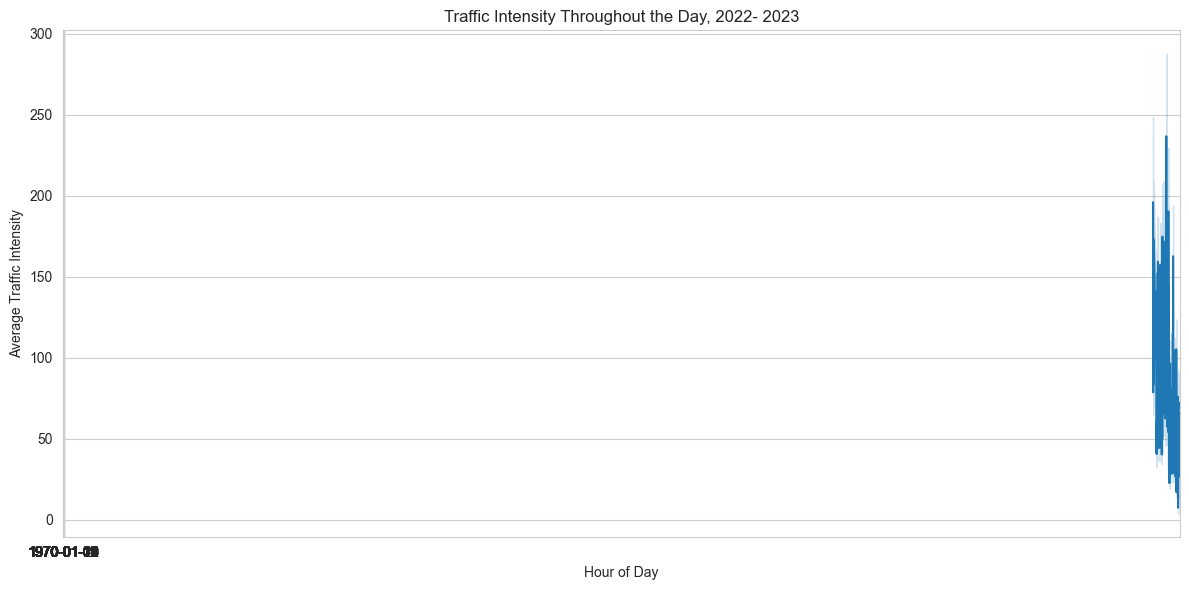

In [21]:
# e Matplotlib, the underlying library used by Seaborn for plotting, does not inherently understand Python datetime.
#date objects for x-axis values. When it encounters datetime.date objects, it defaults to plotting them as if they were 
#numerical values starting from the Unix epoch (January 1, 1970). This is why your dates are not appearing as expected.

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='intensity', data=gap_reset)
plt.title("Traffic Intensity Throughout the Day, 2022- 2023")
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()

Text(0, 0.5, 'Average Traffic Intensity')

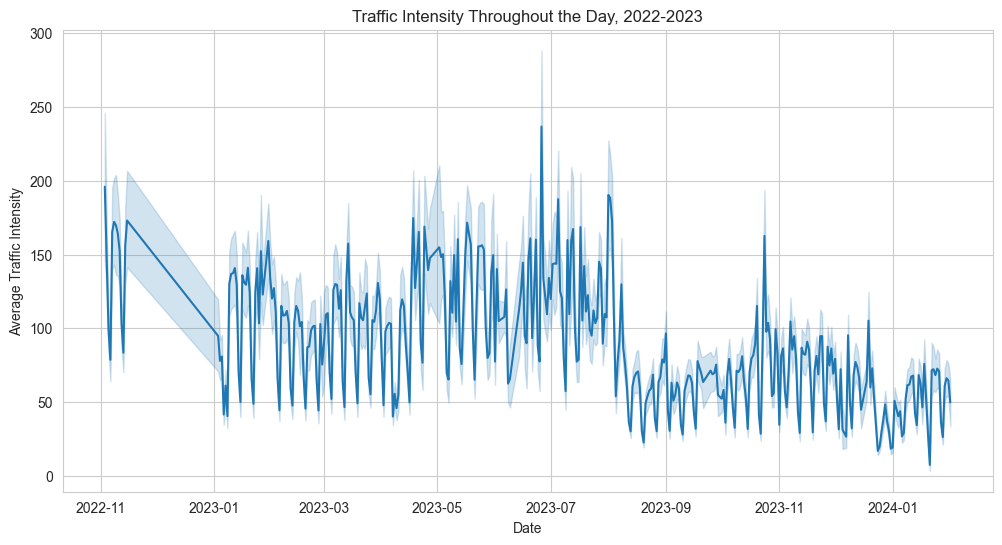

In [22]:
gap_reset['date'] = pd.to_datetime(gap_reset['dateObserved']).dt.normalize()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='intensity', data=gap_reset)
plt.title("Traffic Intensity Throughout the Day, 2022-2023")
plt.xlabel('Date')
plt.ylabel('Average Traffic Intensity')


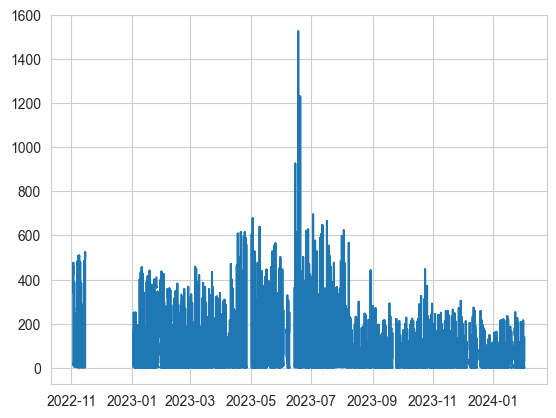

In [23]:
plt.plot(gap_reset.date, gap_reset.intensity)


/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/ipykernel_5525/1967826269.py:3: UserWarning: 
The palette list has fewer values (9870) than needed (9871) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot( x='date', y='intensity', data=gap_reset, hue = gap_reset["intensity"].isna().cumsum(),


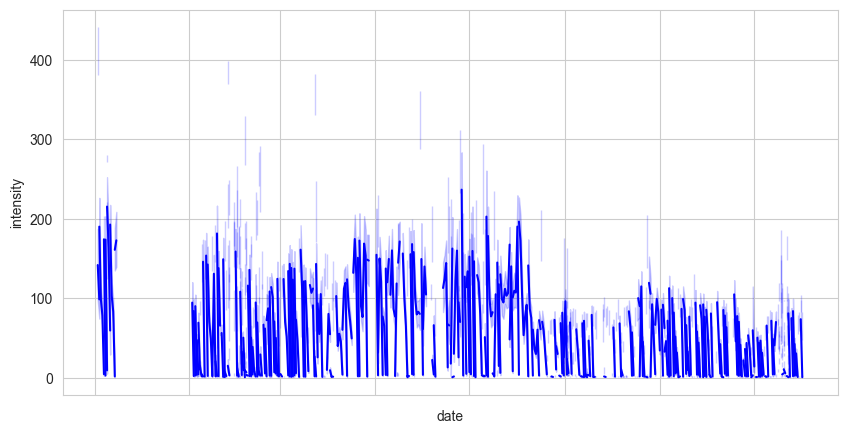

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

plot = sns.lineplot( x='date', y='intensity', data=gap_reset, hue = gap_reset["intensity"].isna().cumsum(),
                    palette=["blue"]*sum(gap_reset["intensity"].isna()),legend=False, markers= False)

ax.set_xticklabels([])

plt.show()

#### gap handling :
first we remove the big gap before the 2023, as we have a whole year to continue with the prediction.

In [25]:
data.shape

(116471, 16)

In [26]:
data2022 = data[data['year'] == 2022]
datafil = data[(data['year'] == 2023) | (data['year'] == 2024)]

datafil_grouped_23_24 = datafil.groupby('dateObserved')[['intensity']].sum()
gap_23_24 = datafil_grouped_23_24.asfreq('15min')
print(f' After focusing on 2023,2024 the data has {gap_23_24.isna().sum().iloc[0]} gaps.')

 After focusing on 2023,2024 the data has 5160 gaps.


In [27]:
data.dtypes

_id                               int64
recvTime            datetime64[ns, UTC]
latitude                        float64
postalCode                        int64
vehicleType                      object
longitude                       float64
dateObservedTo      datetime64[ns, UTC]
dateObserved        datetime64[ns, UTC]
dateObservedFrom    datetime64[ns, UTC]
intensity                         int64
streetAddress                    object
hourOfDay                         int32
date                     datetime64[ns]
year                              int32
month                             int32
days_of_week                     object
dtype: object

In [28]:
data

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress,hourOfDay,date,year,month,days_of_week
0,1,2022-11-03 14:05:24.567000+00:00,49.408167,69115,car,8.66825,2022-11-03 13:55:00+00:00,2022-11-03 13:55:00+00:00,2022-11-03 13:40:00+00:00,243,Bergheimer Straße B37,13,2022-11-03,2022,11,Thursday
1,2,2022-11-03 14:05:24.617000+00:00,49.408167,69115,motorcycle,8.66825,2022-11-03 13:55:00+00:00,2022-11-03 13:55:00+00:00,2022-11-03 13:40:00+00:00,5,Bergheimer Straße B37,13,2022-11-03,2022,11,Thursday
2,3,2022-11-03 14:05:24.666000+00:00,49.408167,69115,van,8.66825,2022-11-03 13:55:00+00:00,2022-11-03 13:55:00+00:00,2022-11-03 13:40:00+00:00,44,Bergheimer Straße B37,13,2022-11-03,2022,11,Thursday
3,4,2022-11-03 14:05:24.666000+00:00,49.408167,69115,lorry,8.66825,2022-11-03 13:55:00+00:00,2022-11-03 13:55:00+00:00,2022-11-03 13:40:00+00:00,46,Bergheimer Straße B37,13,2022-11-03,2022,11,Thursday
4,5,2022-11-03 14:15:20.829000+00:00,49.408167,69115,car,8.66825,2022-11-03 14:10:00+00:00,2022-11-03 14:10:00+00:00,2022-11-03 13:55:00+00:00,273,Bergheimer Straße B37,14,2022-11-03,2022,11,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116466,116883,2024-02-01 09:00:21.544000+00:00,49.408167,69115,lorry,8.66825,2024-02-01 08:55:00+00:00,2024-02-01 08:55:00+00:00,2024-02-01 08:40:00+00:00,10,Bergheimer Straße B37,8,2024-02-01,2024,2,Thursday
116467,116884,2024-02-01 09:15:21.380000+00:00,49.408167,69115,car,8.66825,2024-02-01 09:10:00+00:00,2024-02-01 09:10:00+00:00,2024-02-01 08:55:00+00:00,22,Bergheimer Straße B37,9,2024-02-01,2024,2,Thursday
116468,116885,2024-02-01 09:15:21.666000+00:00,49.408167,69115,motorcycle,8.66825,2024-02-01 09:10:00+00:00,2024-02-01 09:10:00+00:00,2024-02-01 08:55:00+00:00,2,Bergheimer Straße B37,9,2024-02-01,2024,2,Thursday
116469,116886,2024-02-01 09:15:21.872000+00:00,49.408167,69115,van,8.66825,2024-02-01 09:10:00+00:00,2024-02-01 09:10:00+00:00,2024-02-01 08:55:00+00:00,4,Bergheimer Straße B37,9,2024-02-01,2024,2,Thursday


In [29]:
data2022 = data[data['year'] == 2022]
datafil = data[(data['year'] == 2023) | (data['year'] == 2024) & (data['date'] < '2024-01-03')]

datafil_grouped_23_24 = datafil.groupby('dateObserved')[['intensity']].sum()
gap_23_24 = datafil_grouped_23_24.asfreq('15min')
print(f' After reducing the cycle to one year ( 2023/01/03 - 2024/01-02) the data has {gap_23_24.isna().sum().iloc[0]} gaps.')

 After reducing the cycle to one year ( 2023/01/03 - 2024/01-02) the data has 4620 gaps.


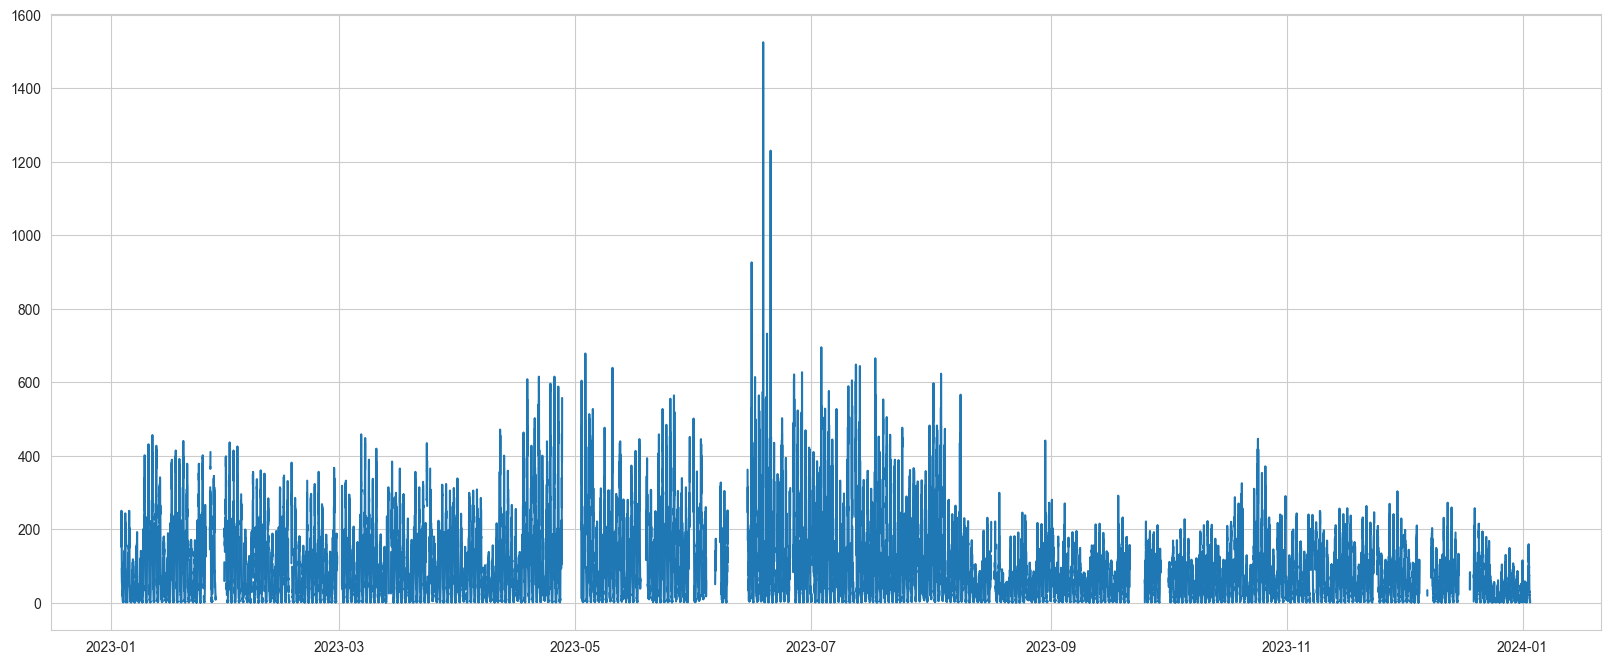

In [30]:
plt.figure(figsize=(20,8))
plt.plot(gap_23_24.index, gap_23_24.intensity)
plt.show()

In [31]:
gap_23_24

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity
dateObserved,
2023-01-03 13:40:00+00:00,166.0
2023-01-03 13:55:00+00:00,152.0
2023-01-03 14:10:00+00:00,183.0
2023-01-03 14:25:00+00:00,201.0
2023-01-03 14:40:00+00:00,233.0
...,...
2024-01-02 22:55:00+00:00,3.0
2024-01-02 23:10:00+00:00,1.0
2024-01-02 23:25:00+00:00,1.0


In [32]:
def fill_with_previous_week(row, df):
    if pd.isna(row['intensity']):
        target_date = row.name - pd.DateOffset(weeks=1)
        print("Target Date:", target_date)  # Debug print

        match = df[(df.index.hour == target_date.hour) & 
                   (df.index.minute == target_date.minute) & 
                   (df.index.weekday == target_date.weekday())]

        print("Matches found:", len(match))  # Debug print

        if not match.empty:
            return match['intensity'].iloc[-1]
        else:
            return np.nan
    else:
        return row['intensity']

In [33]:
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: fill_with_previous_week(row, gap_23_24), axis=1)

Target Date: 2022-12-28 00:40:00+00:00
Matches found: 52
Target Date: 2022-12-28 01:55:00+00:00
Matches found: 52
Target Date: 2022-12-28 02:10:00+00:00
Matches found: 52
Target Date: 2022-12-28 02:25:00+00:00
Matches found: 52
Target Date: 2022-12-28 02:55:00+00:00
Matches found: 52
Target Date: 2022-12-29 01:10:00+00:00
Matches found: 52
Target Date: 2022-12-29 01:40:00+00:00
Matches found: 52
Target Date: 2022-12-29 03:10:00+00:00
Matches found: 52
Target Date: 2022-12-30 00:40:00+00:00
Matches found: 52
Target Date: 2022-12-30 03:40:00+00:00
Matches found: 52
Target Date: 2022-12-31 02:10:00+00:00
Matches found: 52
Target Date: 2022-12-31 03:25:00+00:00
Matches found: 52
Target Date: 2023-01-01 10:25:00+00:00
Matches found: 52
Target Date: 2023-01-01 19:25:00+00:00
Matches found: 52
Target Date: 2023-01-02 00:55:00+00:00
Matches found: 52
Target Date: 2023-01-02 01:55:00+00:00
Matches found: 52
Target Date: 2023-01-02 02:10:00+00:00
Matches found: 52
Target Date: 2023-01-02 02:55:0

In [34]:
gap_23_24['filled_intensity'].isna().sum()

373

In [35]:
gap_23_24

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity,filled_intensity
dateObserved,,
2023-01-03 13:40:00+00:00,166.0,166.0
2023-01-03 13:55:00+00:00,152.0,152.0
2023-01-03 14:10:00+00:00,183.0,183.0
2023-01-03 14:25:00+00:00,201.0,201.0
2023-01-03 14:40:00+00:00,233.0,233.0
...,...,...
2024-01-02 22:55:00+00:00,3.0,3.0
2024-01-02 23:10:00+00:00,1.0,1.0
2024-01-02 23:25:00+00:00,1.0,1.0


In [36]:
mask = gap_23_24['filled_intensity'].isna()
gap_23_24_null = gap_23_24.loc[mask]
gap_23_24_null

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity,filled_intensity
dateObserved,,
2023-01-05 01:10:00+00:00,NaN,NaN
2023-01-05 01:40:00+00:00,NaN,NaN
2023-01-10 00:55:00+00:00,NaN,NaN
2023-01-10 01:10:00+00:00,NaN,NaN
2023-01-12 02:25:00+00:00,NaN,NaN
...,...,...
2024-01-02 02:40:00+00:00,NaN,NaN
2024-01-02 02:55:00+00:00,NaN,NaN
2024-01-02 03:10:00+00:00,NaN,NaN


In [37]:
gap_23_24['ffill_intenstiy']= gap_23_24['intensity'].ffill()
gap_23_24['bfil_intensity']=gap_23_24['intensity'].bfill()


In [38]:
mask = gap_23_24.filled_intensity.isna()
null = gap_23_24.loc[mask,:]
null

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,intensity,filled_intensity,ffill_intenstiy,bfil_intensity
dateObserved,,,,
2023-01-05 01:10:00+00:00,NaN,NaN,4.0,3.0
2023-01-05 01:40:00+00:00,NaN,NaN,3.0,2.0
2023-01-10 00:55:00+00:00,NaN,NaN,1.0,2.0
2023-01-10 01:10:00+00:00,NaN,NaN,1.0,2.0
2023-01-12 02:25:00+00:00,NaN,NaN,2.0,2.0
...,...,...,...,...
2024-01-02 02:40:00+00:00,NaN,NaN,2.0,3.0
2024-01-02 02:55:00+00:00,NaN,NaN,2.0,3.0
2024-01-02 03:10:00+00:00,NaN,NaN,2.0,3.0


In [39]:
gap_23_24['filled_intensity'] = gap_23_24['filled_intensity'].ffill()

In [40]:
gap_23_24= gap_23_24.drop(columns = ['ffill_intenstiy','bfil_intensity'])
gap_23_24.isna().sum()

intensity           4620
filled_intensity       0
dtype: int64

### seperation of Ml and EDA datasets

In [41]:
data_preprocessed = gap_23_24.reset_index()
data_preprocessed.dtypes

dateObserved        datetime64[ns, UTC]
intensity                       float64
filled_intensity                float64
dtype: object

In [42]:
data_ml = gap_23_24.drop(columns = 'intensity')
data_ml

/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,filled_intensity
dateObserved,
2023-01-03 13:40:00+00:00,166.0
2023-01-03 13:55:00+00:00,152.0
2023-01-03 14:10:00+00:00,183.0
2023-01-03 14:25:00+00:00,201.0
2023-01-03 14:40:00+00:00,233.0
...,...
2024-01-02 22:55:00+00:00,3.0
2024-01-02 23:10:00+00:00,1.0
2024-01-02 23:25:00+00:00,1.0


#### frequcney week 

In [43]:
#quarterly frequency, year ends in December: ‘QE’
data_mlw = data_ml.asfreq('W') # weekly frequency

# Train-test dates
# ======================================================================================
iloc_TrainEnd =int(data_mlw.shape[0] - np.ceil(data_mlw.shape[0]*0.2))
print(f"Train dates : {data_mlw.index.min()} --- {data_mlw.iloc[:iloc_TrainEnd].index.max()}  (n={len(data_mlw.iloc[:iloc_TrainEnd])})")
print(f"Test dates  : {data_mlw.iloc[iloc_TrainEnd:].index.min()} --- {data_mlw.iloc[:].index.max()}  (n={len(data_mlw.iloc[iloc_TrainEnd:])})")
data_train = data_mlw.iloc[:iloc_TrainEnd]
data_test  = data_mlw.iloc[iloc_TrainEnd:]


Train dates : 2023-01-08 13:40:00+00:00 --- 2023-10-15 13:40:00+00:00  (n=41)
Test dates  : 2023-10-22 13:40:00+00:00 --- 2023-12-31 13:40:00+00:00  (n=11)


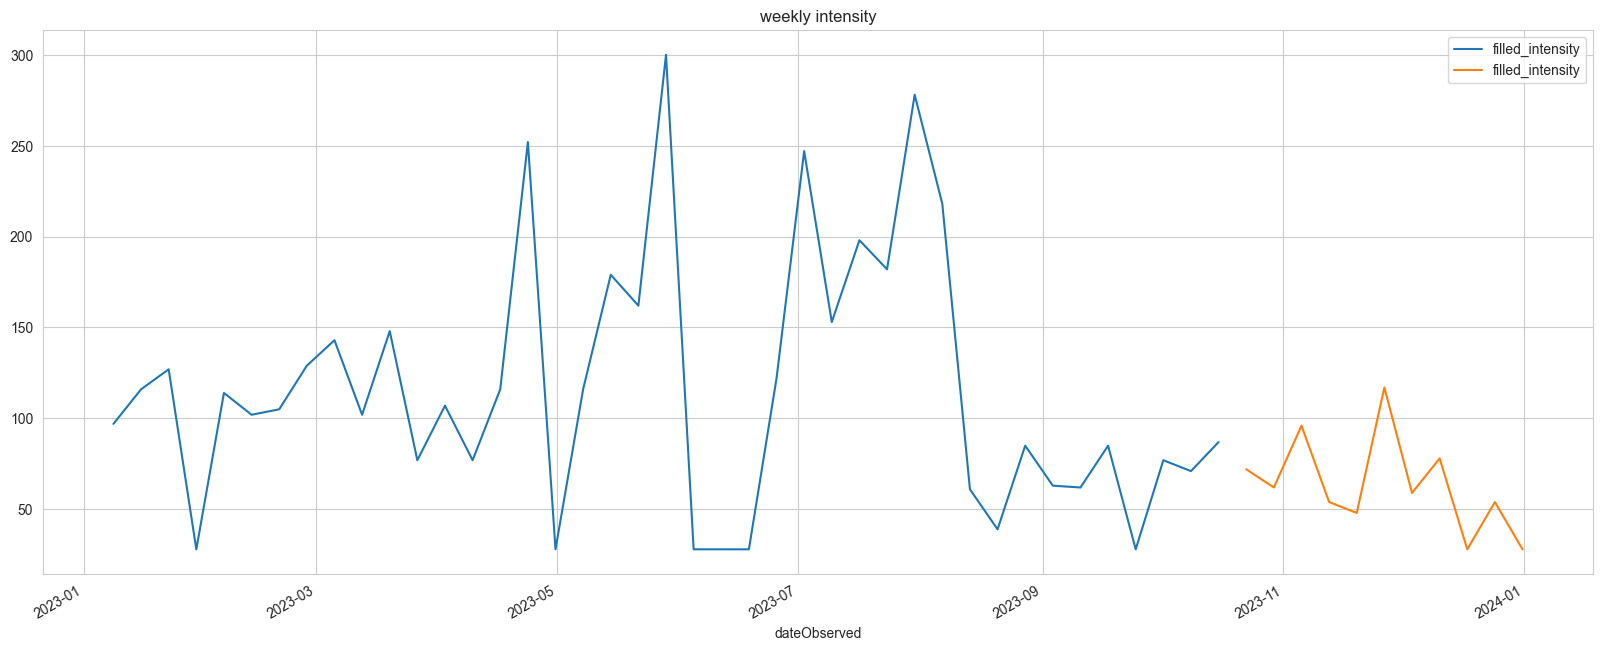

In [44]:
fig, ax=plt.subplots(figsize=(20,8))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('weekly intensity')
ax.legend();

#### frequcney day 

In [52]:
#quarterly frequency, year ends in December: ‘QE’
data_mld = data_ml.asfreq('D') # weekly frequency

# Train-test dates
# ======================================================================================
iloc_TrainEnd =int(data_mld.shape[0] - np.ceil(data_mld.shape[0]*0.3))
print(f"Train dates : {data_mld.index.min()} --- {data_mld.iloc[:iloc_TrainEnd].index.max()}  (n={len(data_mld.iloc[:iloc_TrainEnd])})")
print(f"Test dates  : {data_mld.iloc[iloc_TrainEnd:].index.min()} --- {data_mld.iloc[:].index.max()}  (n={len(data_mld.iloc[iloc_TrainEnd:])})")
data_trainD = data_mld.iloc[:iloc_TrainEnd]
data_testD  = data_mld.iloc[iloc_TrainEnd:]


Train dates : 2023-01-03 13:40:00+00:00 --- 2023-09-14 13:40:00+00:00  (n=255)
Test dates  : 2023-09-15 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=110)


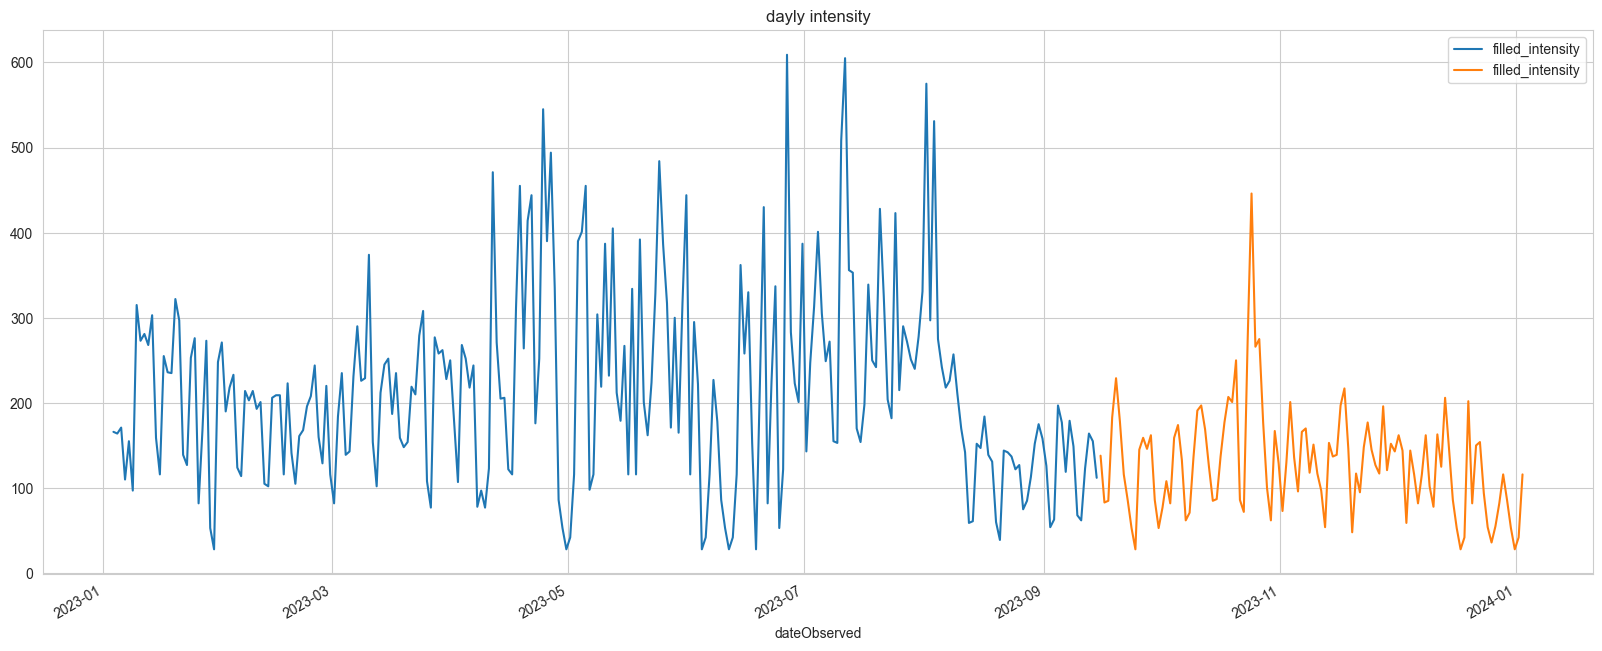

In [53]:
fig, ax=plt.subplots(figsize=(20,8))
data_trainD.plot(ax=ax, label='train')
data_testD.plot(ax=ax, label='test')
ax.set_title('dayly intensity')
ax.legend();

### Exploratory Analysis :

#### Stationarity Anslysis:
using the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test:

**KPSS test** focuses on the presence of trends, and a low p-value indicates non-stationarity due to a trend.
<br>**ADF test** focuses on the presence of a unit root, and a low p-value indicates that the time series does not have a unit root, suggesting it might be stationary.


Test stationarity for original series
-------------------------------------
ADF Statistic: -2.3655168611320856, p-value: 0.15170642820076896
KPSS Statistic: 1.1575505243562485, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.506355579591736, p-value: 4.124770840532069e-11
KPSS Statistic: 0.0541124833253827, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -8.825012184481906, p-value: 1.8335693695262805e-14
KPSS Statistic: 0.04667119604612603, p-value: 0.1


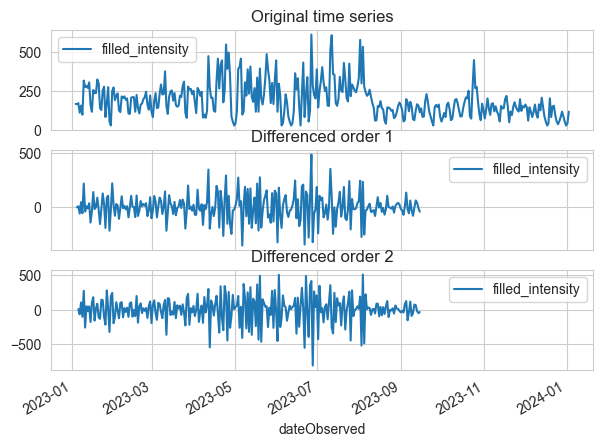

In [54]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_trainD.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data_mld)
kpss_result = kpss(data_mld)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data_mld.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data_mld.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data_mld.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

#### Test Result
This tests provide insights into the time series' properties. 


**Original Series**
<br>**ADF Statistic: -2.3655, p-value: 0.1517**
The ADF test is used to test for the presence of unit root, a sign of non-stationarity. A more negative statistic indicates stronger evidence against the null hypothesis of a unit root (non-stationarity). Here, the p-value is above 0.05, suggesting that you fail to reject the null hypothesis. This implies that the series is non-stationary as per the ADF test.
<br>**KPSS Statistic: 1.1576, p-value: 0.01**
The KPSS test is used to test for the presence of stationarity. Under the null hypothesis, the series is stationary. Given the p-value is less than 0.05, you reject the null hypothesis, implying the series is not stationary.
These results suggest that the original series is not stationary, both according to the ADF (which suggests presence of a unit root) and the KPSS tests (which suggests trend-stationarity is not present).


**Differenced Series (Order 1)**
<br>**ADF Statistic: -8.0939, p-value: ~0**
The ADF test now shows a very negative statistic with a p-value effectively zero, indicating strong evidence against the null hypothesis of a unit root. This suggests the series has become stationary after one differencing.
<br>**KPSS Statistic: 0.0541, p-value: 0.1**
The KPSS test p-value is above 0.05, indicating failure to reject the null hypothesis of stationarity. This confirms that the first differenced series is stationary.


**Differenced Series (Order 2)**
<br>**ADF Statistic: -9.6139, p-value: ~0**
Similarly to the first differencing, the second differencing ADF result is highly negative with a p-value close to zero, which strongly rejects the null hypothesis of a unit root. This indicates the series remains stationary or becomes even more clearly stationary.
<br>**KPSS Statistic: 0.0467, p-value: 0.1**
The KPSS test results continue to suggest stationarity since the p-value is again above 0.05, supporting the null hypothesis of stationarity.

**Interpretation and Next Steps**

**Overall Analysis:** After checking the first and second-order differences, the p-value indicates a statistically significant decrease below the widely-recognized and accepted threshold of 0.05 for order=1. The first differencing is sufficient to achieve stationarity based on both tests. **Therefore, the most appropriate selection for the ARIMA parameter  d  is 1.** As the first differencing has already stabilized the mean and variance,there is  no need to go to second differencing, as excessive differencing can lead to over-differencing, where the series may start showing artificial patterns.

**Model Building:** With the first differenced series confirmed stationary, you can proceed to build time series forecasting models such as ARIMA, **specifying d=1** for the differencing order in an ARIMA model or D=1 in a seasonal order of a SARIMA or SARIMAX model if seasonal patterns are also considered.

**Visual Check:** The plots show a visibly more stable mean and variance in the first and second differenced series compared to the original series, aligning with our statistical tests.

#### Autocorrelation Analysis

Since the **Stationarity Analysis** indicates that **differencing is required**, subsequent analyses should be conducted using the differenced series, as this will align with the manner in which the ARIMA model interprets the series.

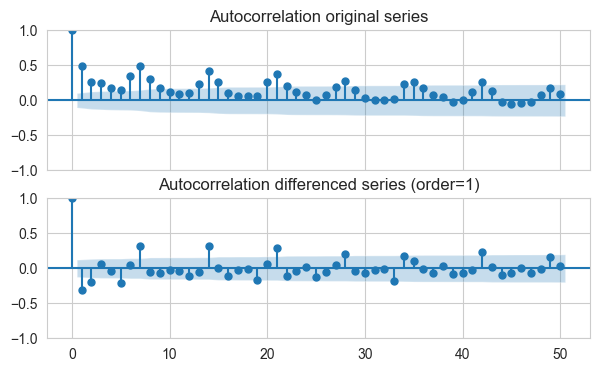

In [56]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data_mld, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');


#### Question !!
**?? No sharp drop-off?? ACF displays a sinusoidal pattern, it suggests seasonality is present and requires consideration of seasonal orders in addition to non-seasonal orders.??

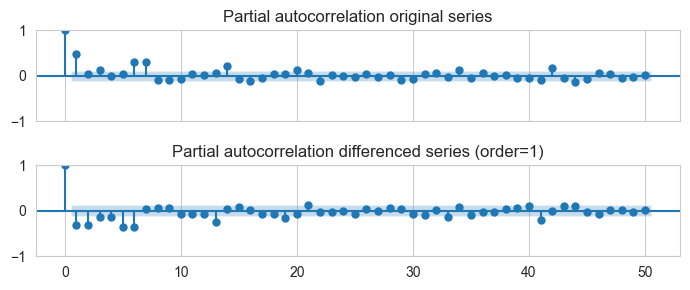

In [57]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data_mld, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();


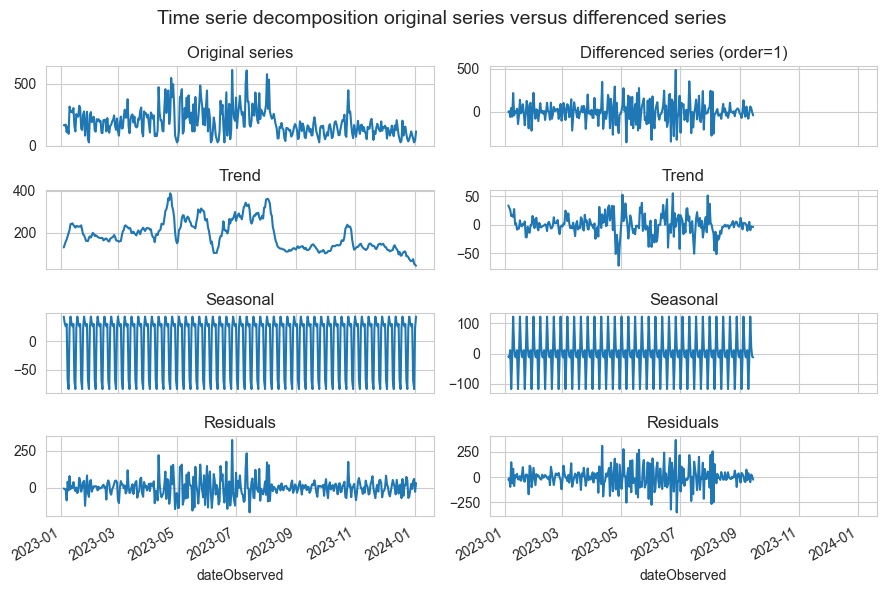

In [58]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data_mld, model='additive', extrapolate_trend='freq')
res_descompose_diff_1 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_1.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_1.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_1.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_1.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();


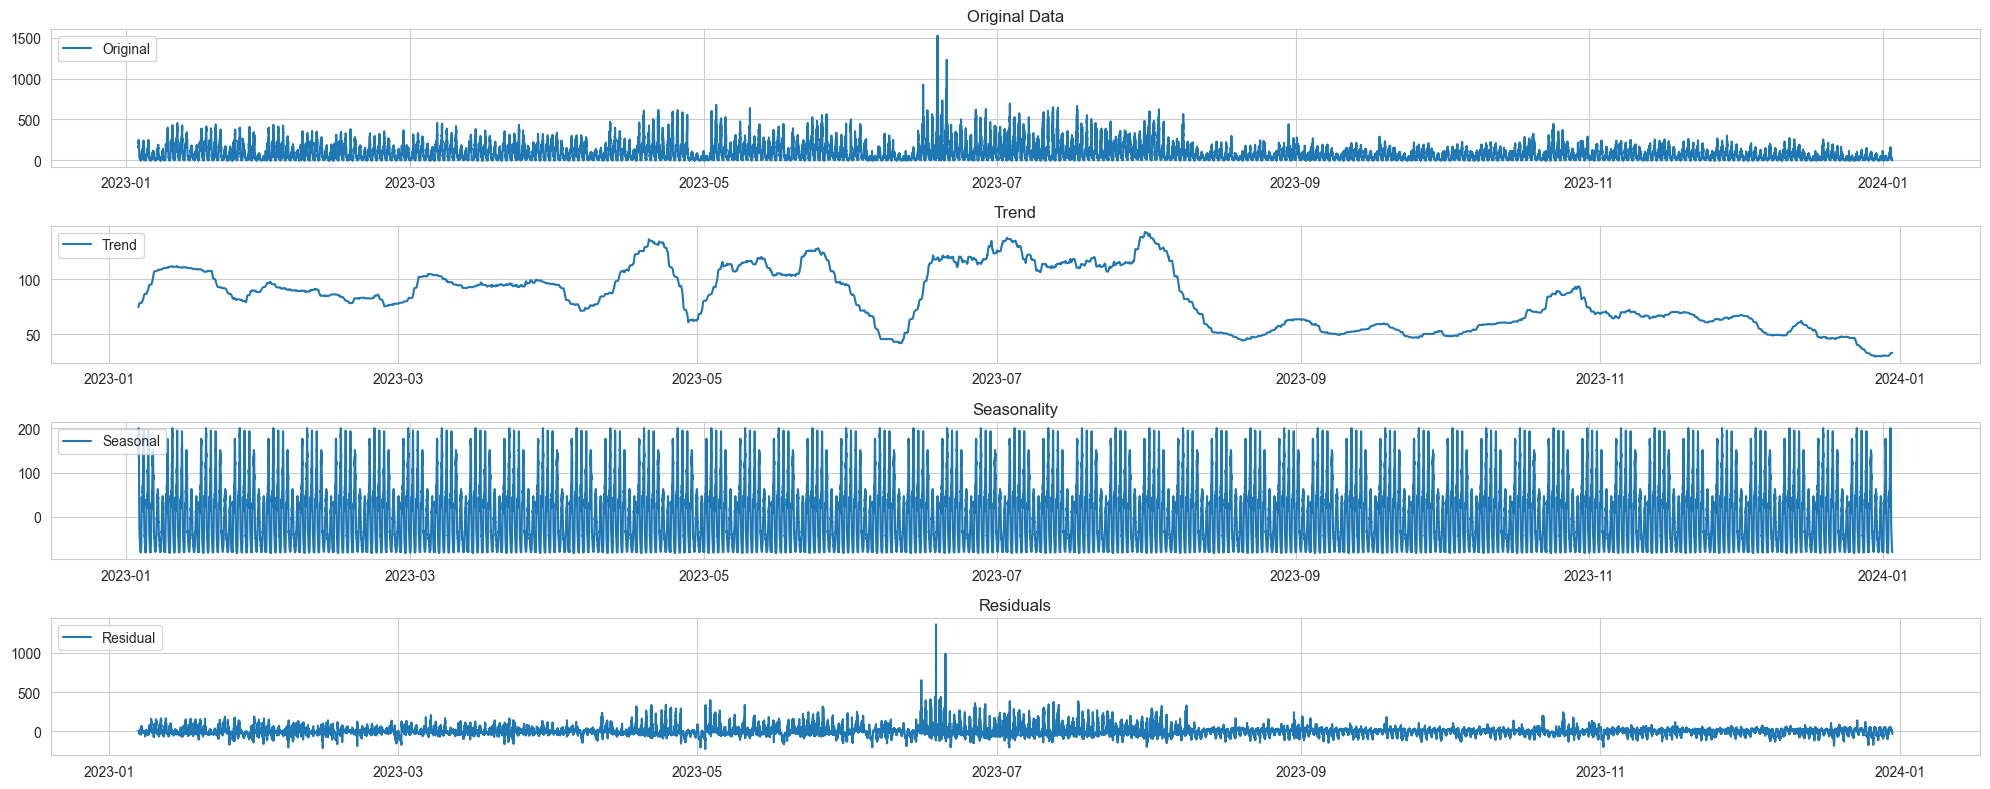

In [119]:
trend = decompose_data.trend
seasonal = decompose_data.seasonal
residual = decompose_data.resid

fig, axes = plt.subplots(4, 1, figsize=(20, 8)) 

axes[0].plot(data_ml['filled_intensity'], label='Original')
axes[0].legend(loc='upper left')
axes[0].set_title('Original Data')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')
axes[1].set_title('Trend')

axes[2].plot(seasonal, label='Seasonal')
axes[2].legend(loc='upper left')
axes[2].set_title('Seasonality')

axes[3].plot(residual, label='Residual')
axes[3].legend(loc='upper left')
axes[3].set_title('Residuals')

# Improve layout to prevent label overlap
plt.tight_layout()
plt.show()


### Exploratory Data Analysis

In [77]:
data_preprocessed['hourOfDay']=data_preprocessed['dateObserved'].dt.hour
data_preprocessed['date']=data_preprocessed['dateObserved'].dt.date
data_preprocessed['date'] = pd.to_datetime(data_preprocessed['date'])
data_preprocessed['year'] = data_preprocessed['date'].dt.year
data_preprocessed['month_number'] = data_preprocessed['date'].dt.month
data_preprocessed['month'] = data_preprocessed['date'].dt.month_name()
data_preprocessed['days_of_week'] = data_preprocessed['date'].dt.day_name()

#### Traffic intensity variation throughout the day

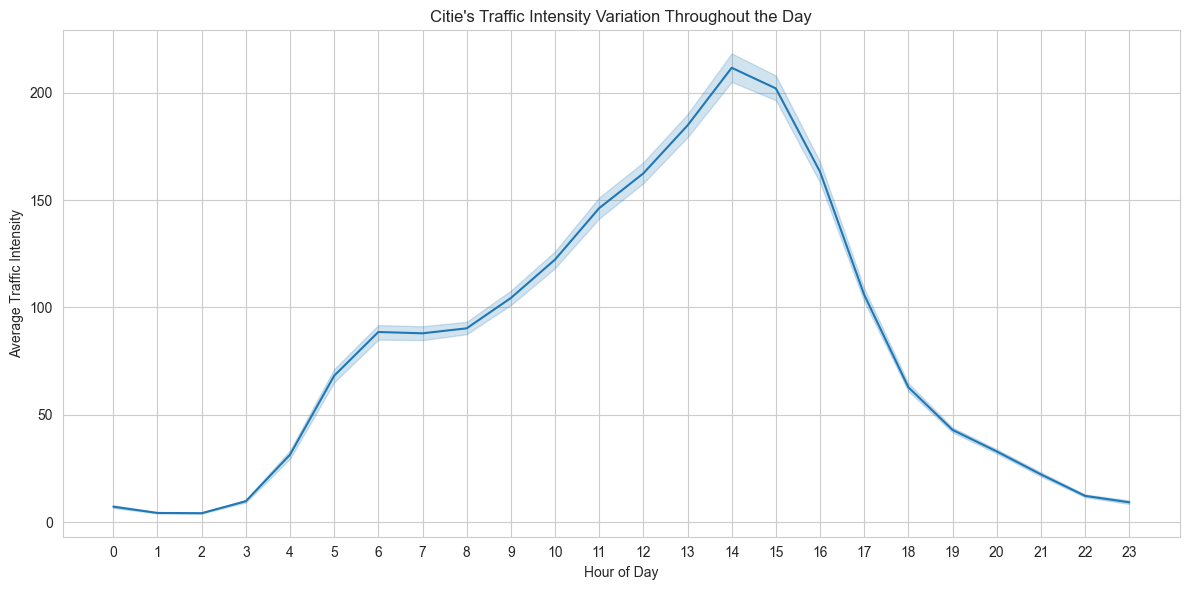

In [79]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='filled_intensity', data=data_preprocessed, estimator='mean' )
plt.title("Citie's Traffic Intensity Variation Throughout the Day")
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()

#note estimatorname : Method for aggregating across multiple observations of the y variable at the same x level. If None, all observations will be drawn.

<Axes: xlabel='vehicleType', ylabel='intensity'>

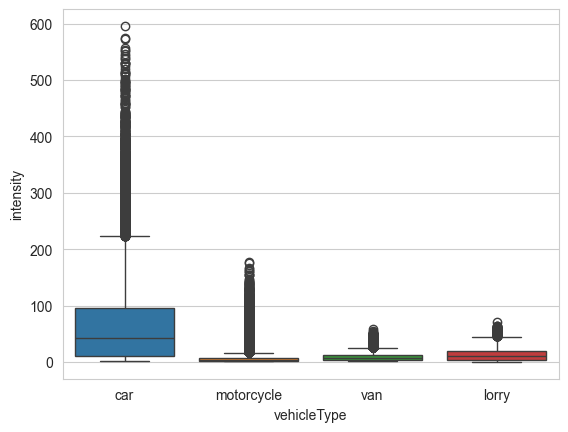

In [80]:
sns.boxplot(data=data, x ='vehicleType' , y='intensity', hue='vehicleType')

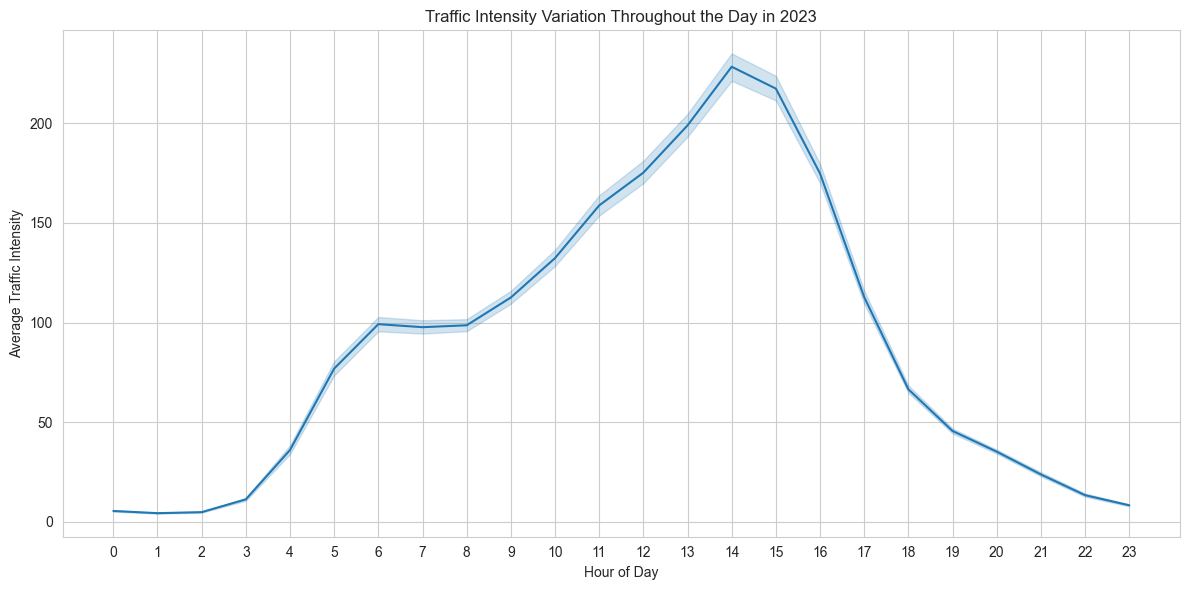

In [81]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity', data=data_preprocessed[(data_preprocessed['year']==2023)], estimator='mean')
plt.title('Traffic Intensity Variation Throughout the Day in 2023')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


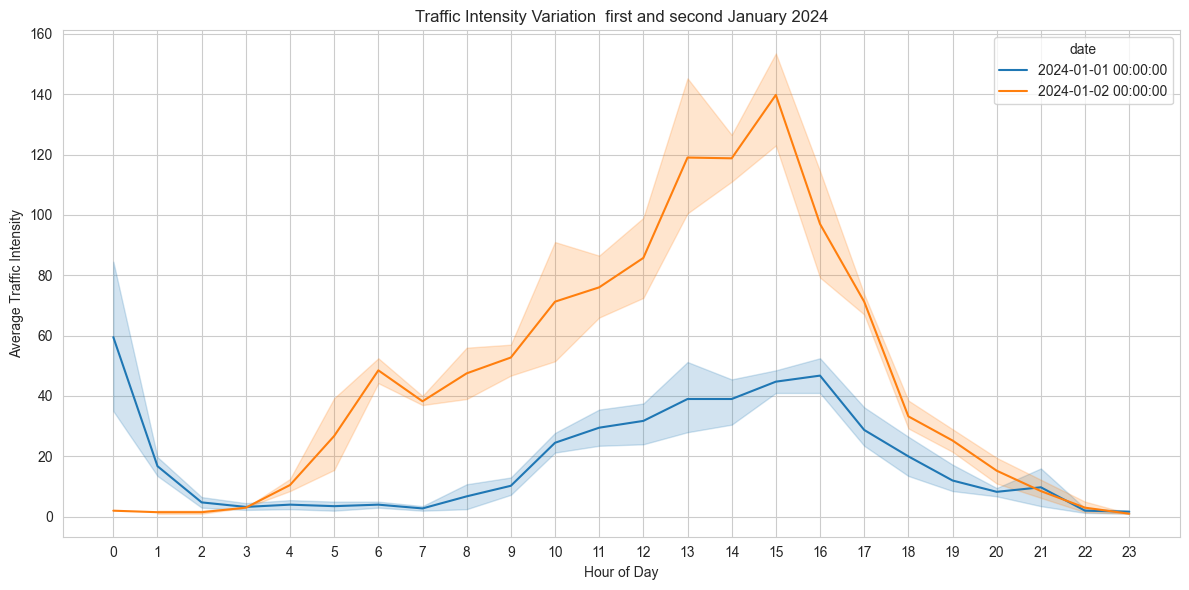

In [82]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity',hue='date', data=data_preprocessed[(data_preprocessed['year']==2024)], estimator='mean')
plt.title('Traffic Intensity Variation  first and second January 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


In [83]:
data_preprocessed.head()

,dateObserved,intensity,filled_intensity,hourOfDay,date,year,month_number,month,days_of_week
0,2023-01-03 13:40:00+00:00,166.0,166.0,13,2023-01-03,2023,1,January,Tuesday
1,2023-01-03 13:55:00+00:00,152.0,152.0,13,2023-01-03,2023,1,January,Tuesday
2,2023-01-03 14:10:00+00:00,183.0,183.0,14,2023-01-03,2023,1,January,Tuesday
3,2023-01-03 14:25:00+00:00,201.0,201.0,14,2023-01-03,2023,1,January,Tuesday
4,2023-01-03 14:40:00+00:00,233.0,233.0,14,2023-01-03,2023,1,January,Tuesday


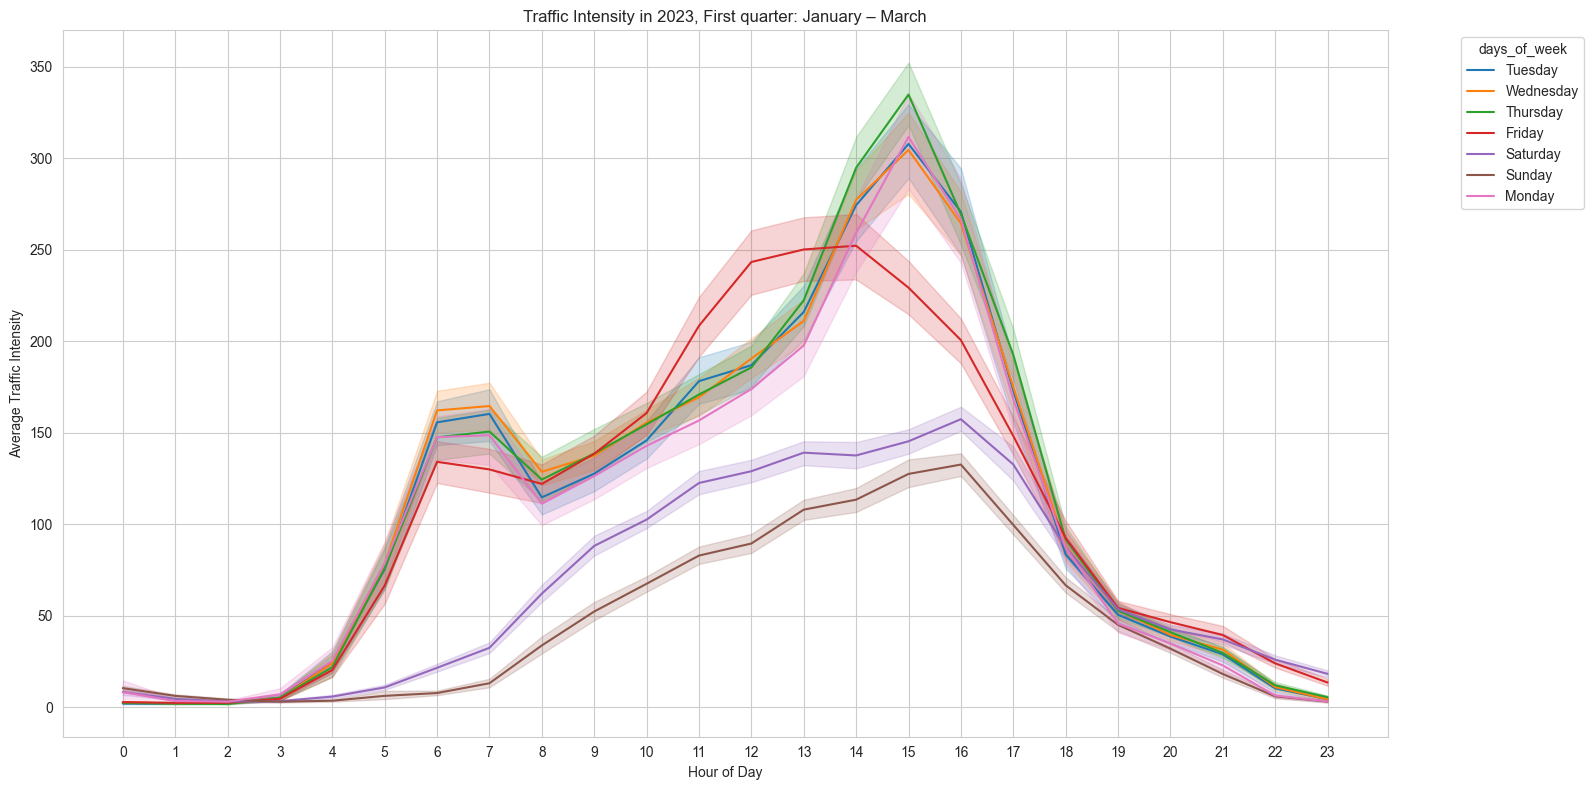

In [84]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='days_of_week',
             data=data_preprocessed[data_preprocessed['month_number']<=3],
             estimator='mean')

plt.title(f'Traffic Intensity in 2023, First quarter: January – March')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.legend(title='days_of_week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

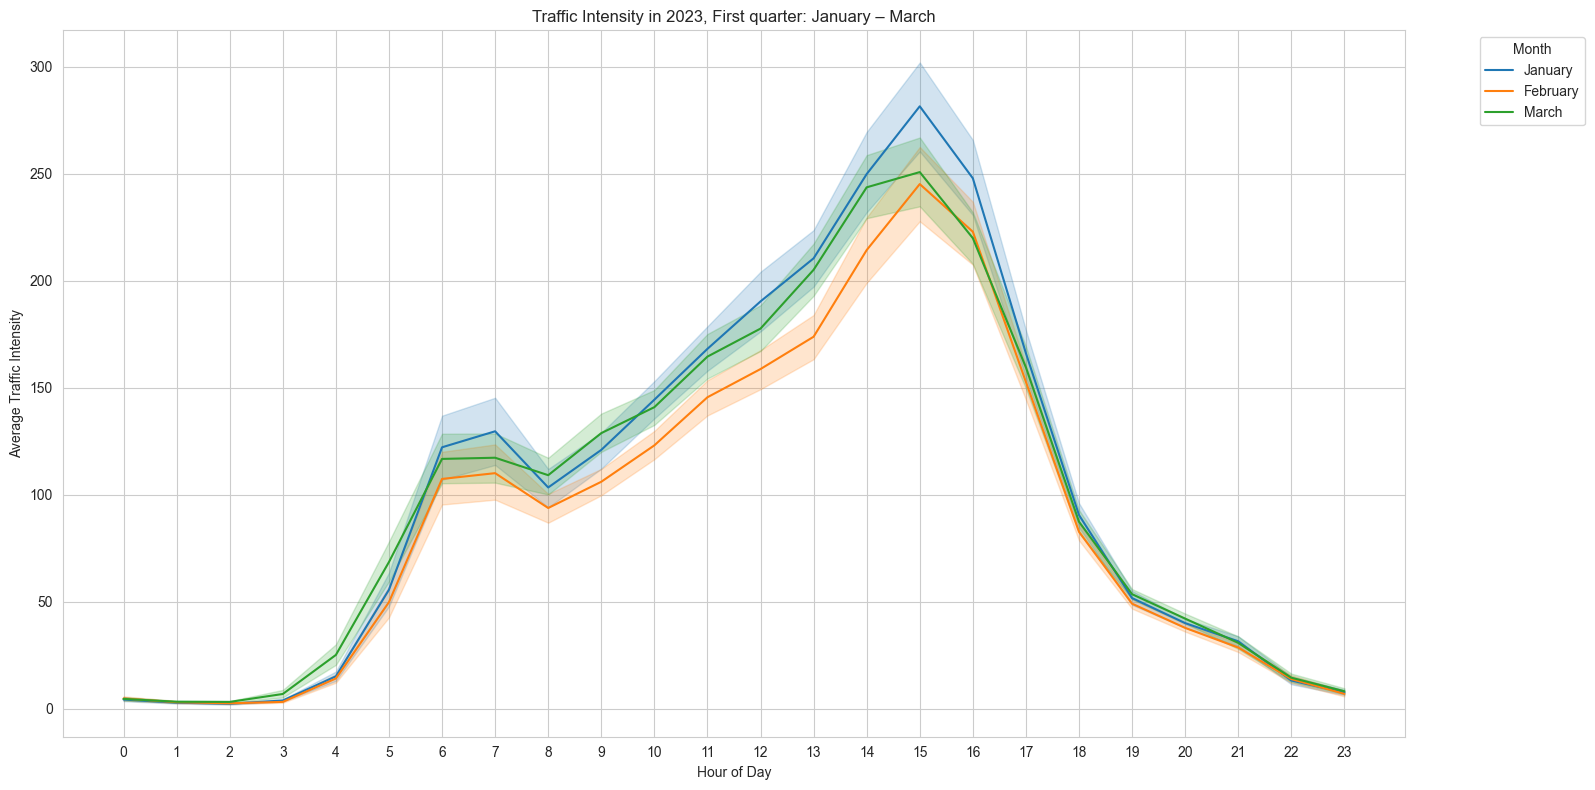

In [85]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='month',
             data=data_preprocessed[(data_preprocessed['year'] == 2023) &(data_preprocessed['month_number']<=3)],
             estimator='mean')

plt.title(f'Traffic Intensity in 2023, First quarter: January – March')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

#### One-hot encoding

In [ ]:
data.vehicleType.unique()

In [ ]:
# One-hot encode 'vehicleType'
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [ ]:
# One-hot encode locations
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [ ]:
print(data.index.is_unique)
print(vehicle_type_encoded_df.index.is_unique)

In [ ]:
data_vehicle_encoded= pd.concat([data, vehicle_type_encoded_df], axis=1)

#### Traffic intensity by vehicleType

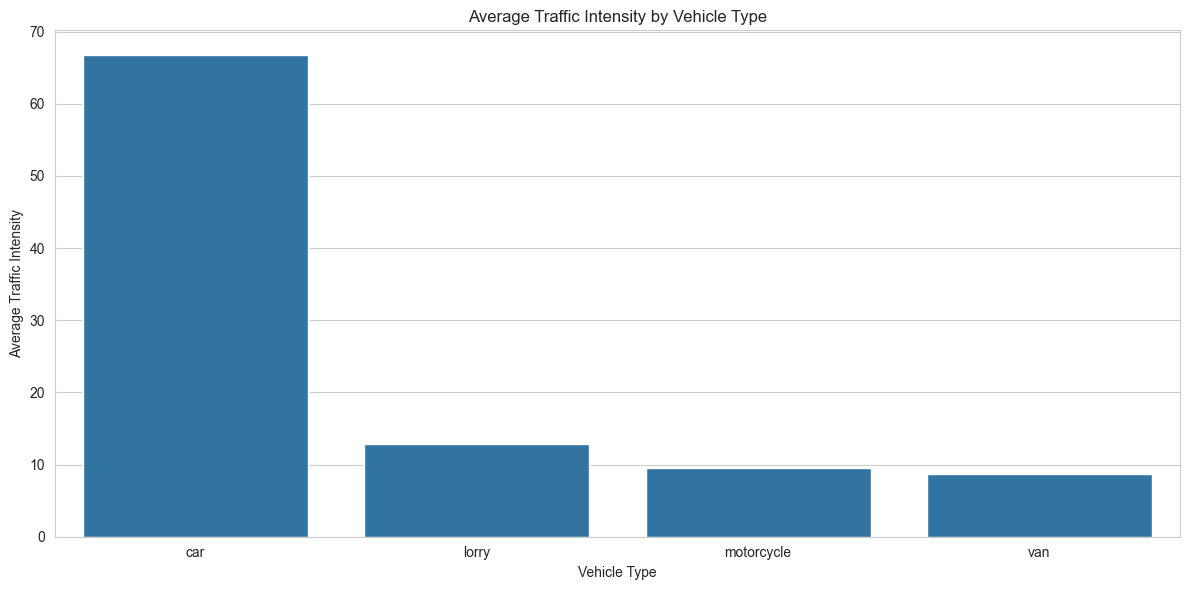

In [86]:
vehicle_types = encoder.categories_[0]
average_intensities = [data_vehicle_encoded.loc[data_vehicle_encoded[vehicle_type] == 1, 'intensity'].mean() for vehicle_type in vehicle_type_encoded_df.columns]
plt.figure(figsize=(12, 6))
sns.barplot(x=vehicle_types, y=average_intensities)
plt.title('Average Traffic Intensity by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Traffic Intensity')
plt.tight_layout()
plt.show()

## Machine Learning

In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor

In [40]:
# Preparation 
features = pd.concat([data_preprocessed[['hourOfDay', 'latitude', 'longitude']], vehicle_type_encoded_df], axis=1)
target = data_preprocessed['intensity']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

### Tree-based model

####  Decision Tree Regressor

In [41]:
# note no need to normalize

decision_tree_model = DecisionTreeRegressor(random_state=10)
decision_tree_model.fit(X_train, y_train)


y_pred = decision_tree_model.predict(X_test)

# Evaluaton
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, R^2: {r2}')


MSE: 393.2635337007132, RMSE: 19.830873246045247, R^2: 0.66001904219095


### Non-tree-based model

In [42]:

models = {
    'Bagging': BaggingRegressor(random_state=10),
    'AdaBoost': AdaBoostRegressor(random_state=10),
    'RandomForest': RandomForestRegressor(random_state=10)
}

# Dictionary of results
results = {}

# fit, predict, and evaluate
for name, model in models.items():    

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    results[name] = (mse, rmse, r2)

for model, metrics in results.items():
    print(f"{model} - MSE: {metrics[0]}, RMSE: {metrics[1]}, R^2: {metrics[2]}")


Bagging - MSE: 393.27817283923, RMSE: 19.831242342304982, R^2: 0.6600063864832426
AdaBoost - MSE: 683.2700522217565, RMSE: 26.139434810679372, R^2: 0.409304990445975
RandomForest - MSE: 393.2701800087117, RMSE: 19.831040820106033, R^2: 0.660013296379387


### Scaling 

In [43]:
normalizer = MinMaxScaler()

# training dataset 
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [44]:

model = KNeighborsRegressor()
model.fit(X_train_norm, y_train)
    
# Prediction and evaluation
y_pred = model.predict(X_test_norm)
    
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
    
print(f"{model} - MSE: {metrics[0]}, RMSE: {metrics[1]}, R^2: {metrics[2]}")


KNeighborsRegressor() - MSE: 393.2701800087117, RMSE: 19.831040820106033, R^2: 0.660013296379387
